In [13]:
from transformers import AutoModel, AutoTokenizer
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2,3'
model_name = 'deepseek-ai/DeepSeek-OCR'

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name, _attn_implementation='flash_attention_2', trust_remote_code=True, use_safetensors=True)
model = model.eval().cuda().to(torch.bfloat16)

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at deepseek-ai/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
model.device

device(type='cuda', index=0)

In [11]:
# prompt = "<image>\nFree OCR. "
prompt = "<image>\n<|grounding|>Convert the document to markdown. "
image_file = 'data/airbus_table.png'
output_path = 'data/output'

# infer(self, tokenizer, prompt='', image_file='', output_path = ' ', base_size = 1024, image_size = 640, crop_mode = True, test_compress = False, save_results = False):

# Tiny: base_size = 512, image_size = 512, crop_mode = False
# Small: base_size = 640, image_size = 640, crop_mode = False
# Base: base_size = 1024, image_size = 1024, crop_mode = False
# Large: base_size = 1280, image_size = 1280, crop_mode = False

# Gundam: base_size = 1024, image_size = 640, crop_mode = True

res = model.infer(tokenizer, prompt=prompt, image_file=image_file, output_path = output_path, base_size = 1280, image_size = 640, crop_mode=True, save_results = False, test_compress = True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 400, 1280])
NO PATCHES
<|ref|>table<|/ref|><|det|>[[0, 0, 999, 999]]<|/det|>
<table><tr><td>Granted Date</td><td>LTIP 2019</td><td>LTIP 2020</td><td>LTIP 2021</td><td>LTIP 2022</td><td>LTIP 2023</td><td>LTIP 2024</td></tr><tr><td>Performance Units and Shares</td><td>11,060</td><td>19,840</td><td>12,121</td><td>14,115</td><td>11,619</td><td>10,839</td></tr><tr><td>Revaluation</td><td>50%</td><td>150%</td><td>96%</td><td>100%</td><td>100%</td><td>100%</td></tr><tr><td>Performance Units and Shares revalued</td><td>5,531</td><td>29,760</td><td>11,636</td><td>14,115</td><td>11,619</td><td>10,839</td></tr><tr><td>Vested in 2024</td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td>in cash</td><td>1,383</td><td>7,440</td><td>-</td><td>-</td><td>-</td><td>-</td></tr><tr><td>in shares</td><td>-</td><td>14,880</td><td>-</td><td>-</td><td>-</td><td>-</td></tr><tr><td>Outstanding 2024</td><td></td><td></td><td></td><td></td><td></td><td></td></tr><tr><td>In c

image: 0it [00:00, ?it/s]
other: 100%|██████████| 1/1 [00:00<00:00, 35246.25it/s]


In [7]:
res2 = model.infer(tokenizer, prompt=prompt, image_file=image_file, output_path = output_path, base_size = 512, image_size = 512, crop_mode=False, save_results = True, test_compress = True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


directly resize
BASE:  torch.Size([1, 64, 1280])
NO PATCHES
<|ref|>sub_title<|/ref|><|det|>[[35, 160, 260, 174]]<|/det|>
## Post-Employment Benefit Costs 

<|ref|>text<|/ref|><|det|>[[35, 177, 470, 217]]<|/det|>
Post-employment benefit costs relate to the aggregated amount of current service units costs for defined benefit plan and company cost for contributions base plans. 

<|ref|>text<|/ref|><|det|>[[35, 230, 470, 270]]<|/det|>
Following the Board decision approving the A&M 2003, the CEO pension committee voted unanimously a defined contribution plan (summary plan), which coexists with the former defined benefit pension plan. 

<|ref|>text<|/ref|><|det|>[[35, 283, 470, 336]]<|/det|>
The accrued expense under the former defined benefit plan base plan was the end of 2009 and represents unrealized net the retirement date of the CEO. The pension plan adopted the Company's defined contribution plan are described from the treasury defined pension register. 

<|ref|>text<|/ref|><|det|>[[35

image: 0it [00:00, ?it/s]
other: 100%|██████████| 19/19 [00:00<00:00, 176309.24it/s]


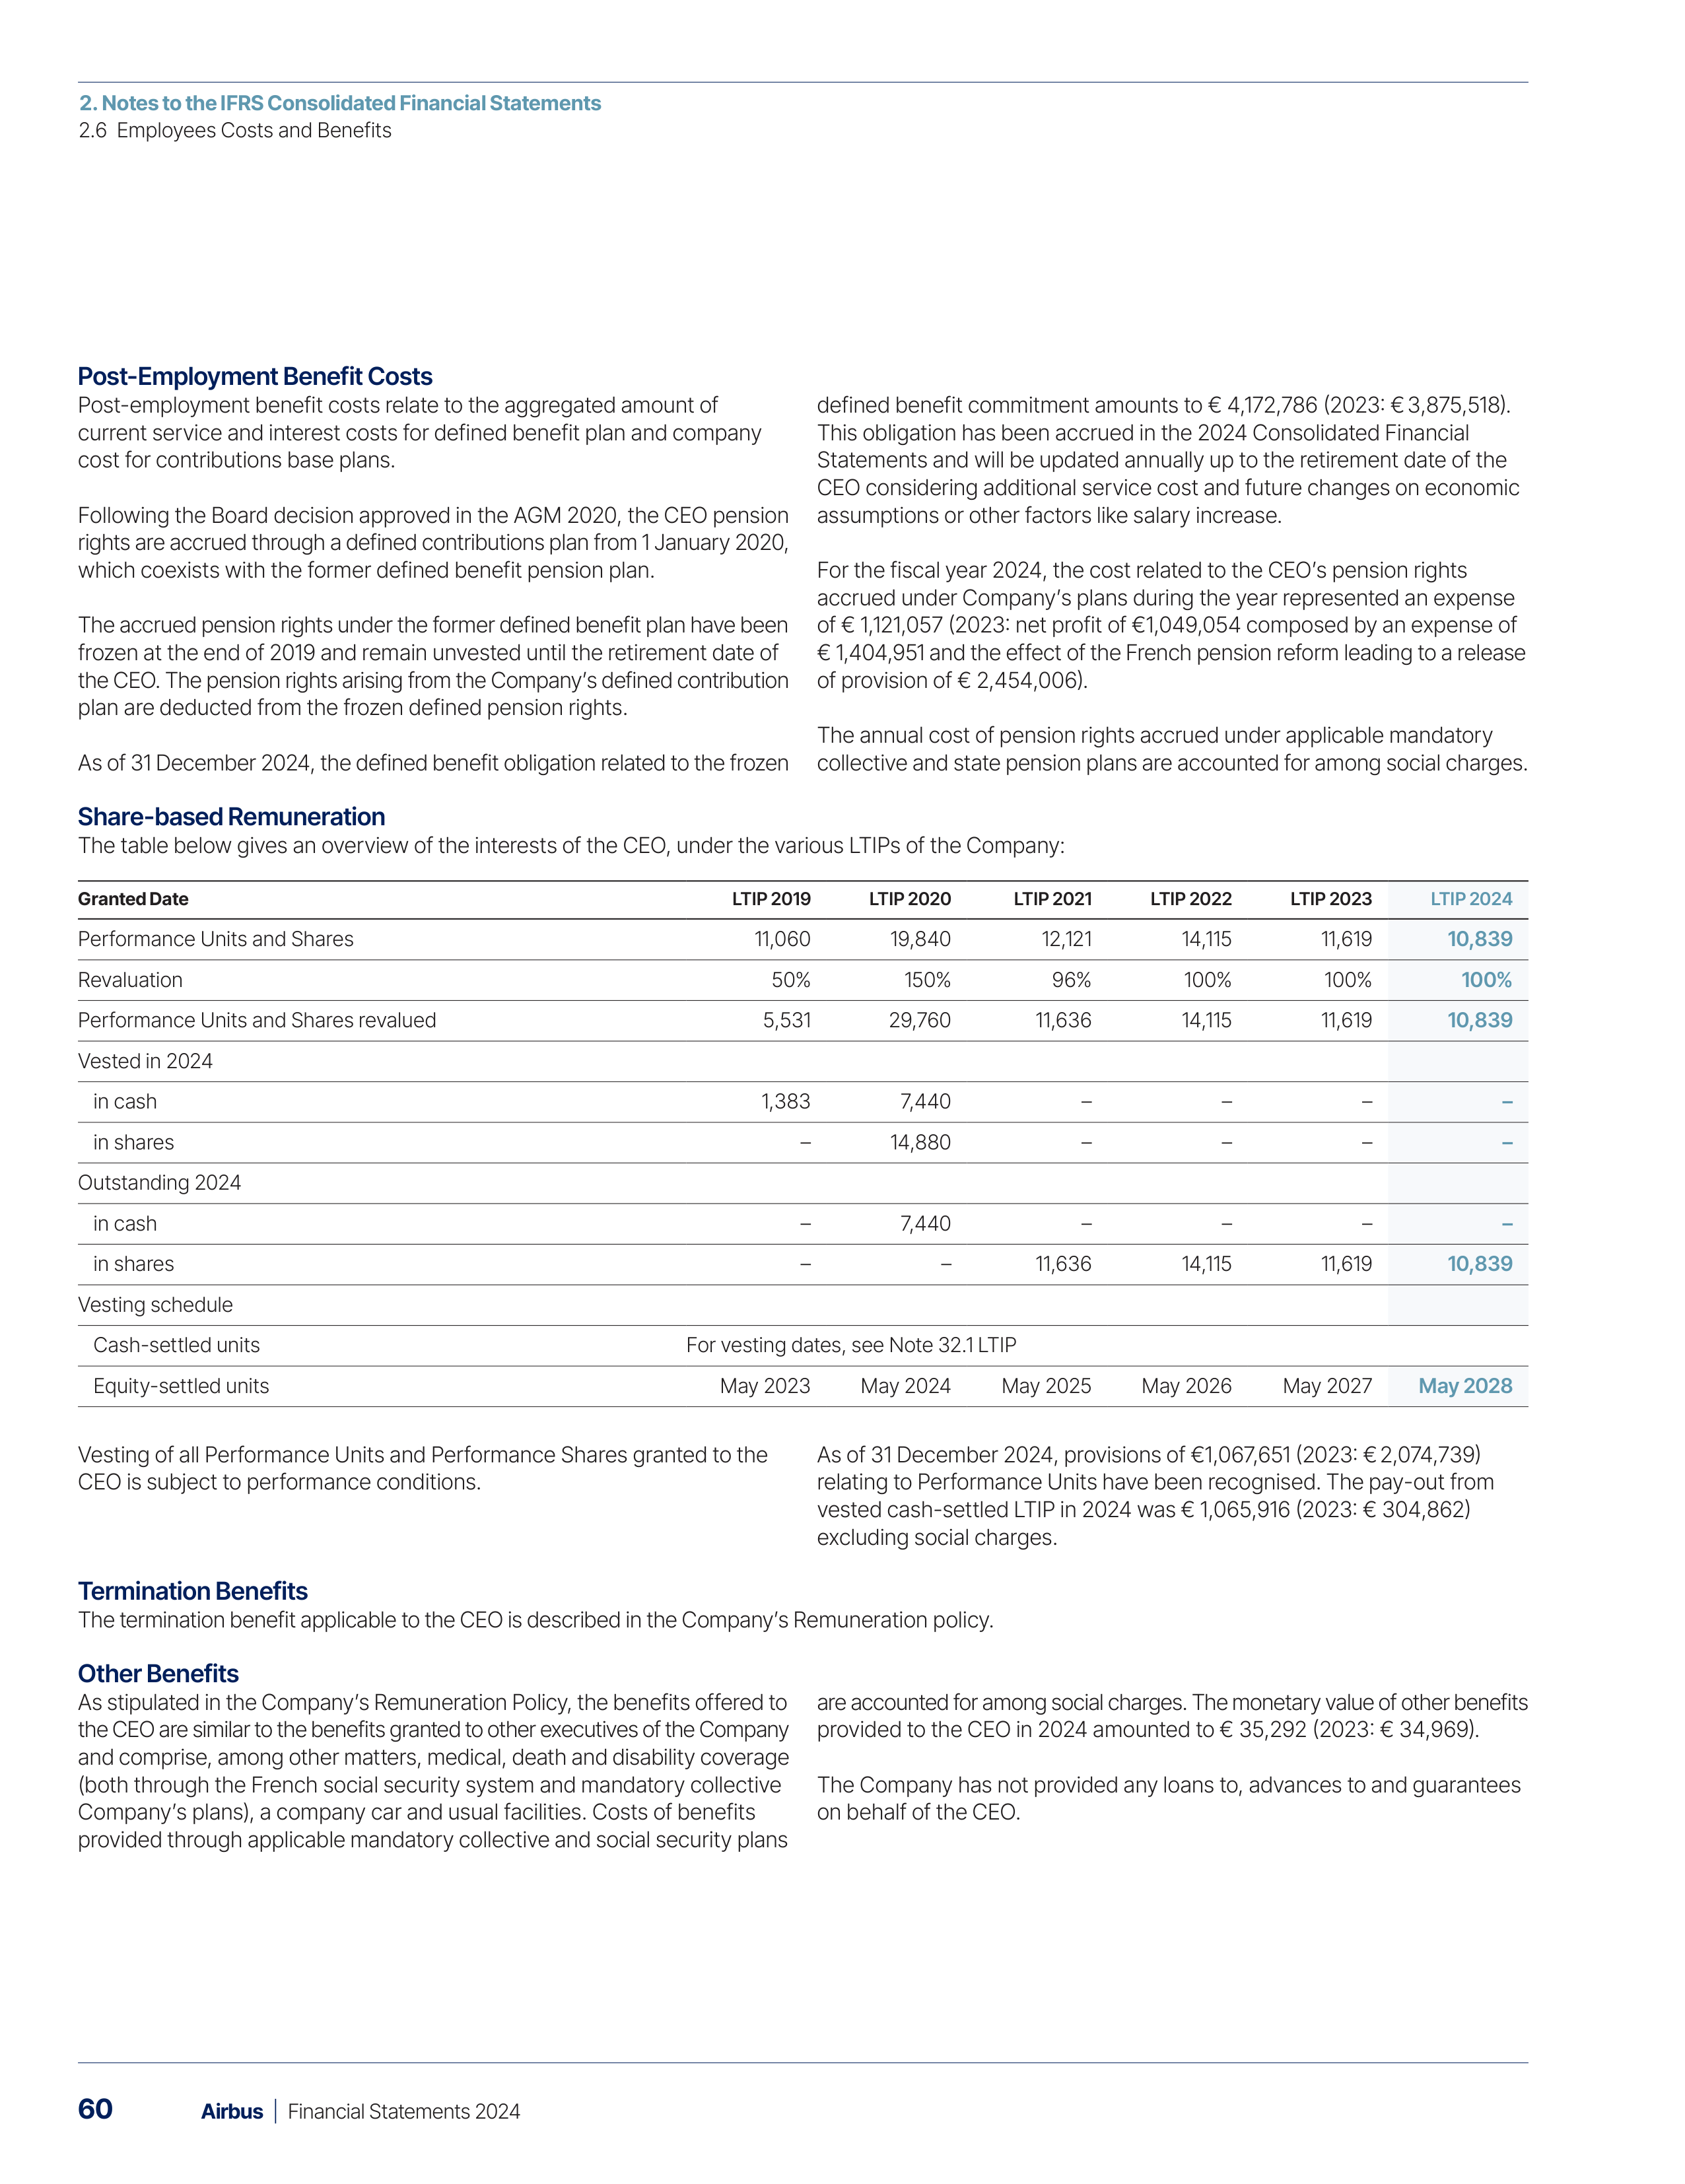

In [27]:
import io
import os
import tempfile
from typing import List, Optional, Union

import fitz  # PyMuPDF
from PIL import Image


def pdf_to_images(
    pdf_source: Union[bytes, str],
    dpi: int = 300,
    start_page: int = 0,
    end_page: Optional[int] = None,
    as_rgb: bool = True,
) -> List[Image.Image]:
    """
    Convert a PDF (bytes or file path) to a list of PIL Images.

    Args:
        pdf_source: PDF bytes or path to PDF file.
        dpi: Output resolution in dots per inch (higher -> larger images).
        start_page: zero-based first page to convert.
        end_page: zero-based (exclusive) end page. If None -> convert to last page.
        as_rgb: if True convert images to RGB (useful to avoid palette/LA issues).

    Returns:
        List of PIL.Image objects, one per converted page.

    Raises:
        FileNotFoundError if pdf_source is a path that doesn't exist.
        ValueError for invalid page ranges.
        RuntimeError for other failures.
    """
    temp_path = None
    created_temp = False

    # handle bytes input by writing to a temporary file
    if isinstance(pdf_source, (bytes, bytearray)):
        fd, temp_path = tempfile.mkstemp(suffix=".pdf")
        created_temp = True
        try:
            with os.fdopen(fd, "wb") as tmp:
                tmp.write(pdf_source)
        except Exception:
            # ensure file descriptor closed and file removed on failure
            try:
                os.unlink(temp_path)
            except Exception:
                pass
            raise

    elif isinstance(pdf_source, str):
        if not os.path.exists(pdf_source):
            raise FileNotFoundError(f"PDF file not found: {pdf_source}")
        temp_path = pdf_source
    else:
        raise TypeError("pdf_source must be bytes or a filesystem path (str)")

    images: List[Image.Image] = []
    try:
        doc = fitz.open(temp_path)
        page_count = doc.page_count

        if end_page is None:
            end_page = page_count
        # sanity check page range
        if not (0 <= start_page < page_count) and page_count > 0:
            raise ValueError("start_page out of range")
        if not (start_page <= end_page <= page_count):
            raise ValueError("invalid start_page/end_page")

        zoom = dpi / 72.0
        matrix = fitz.Matrix(zoom, zoom)

        for pno in range(start_page, end_page):
            page = doc[pno]
            pix = page.get_pixmap(matrix=matrix, alpha=False)  # alpha=False for opaque
            img_bytes = pix.tobytes("png")  # use PNG bytes -> reliable with PIL
            img = Image.open(io.BytesIO(img_bytes))
            if as_rgb:
                img = img.convert("RGB")
            images.append(img)

        doc.close()
    except Exception as e:
        # include some context
        raise RuntimeError(f"Failed to convert PDF to images: {e}") from e
    finally:
        # cleanup only if we created a temporary file
        if created_temp and temp_path is not None:
            try:
                os.unlink(temp_path)
            except Exception:
                pass

    return images



with open('data/Airbus_24.pdf', 'rb') as f:
    report = f.read()

images = pdf_to_images(report, start_page = 302, end_page = 305)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
image: 0it [00:00, ?it/s]
other: 100%|██████████| 4/4 [00:00<00:00, 62137.84it/s]


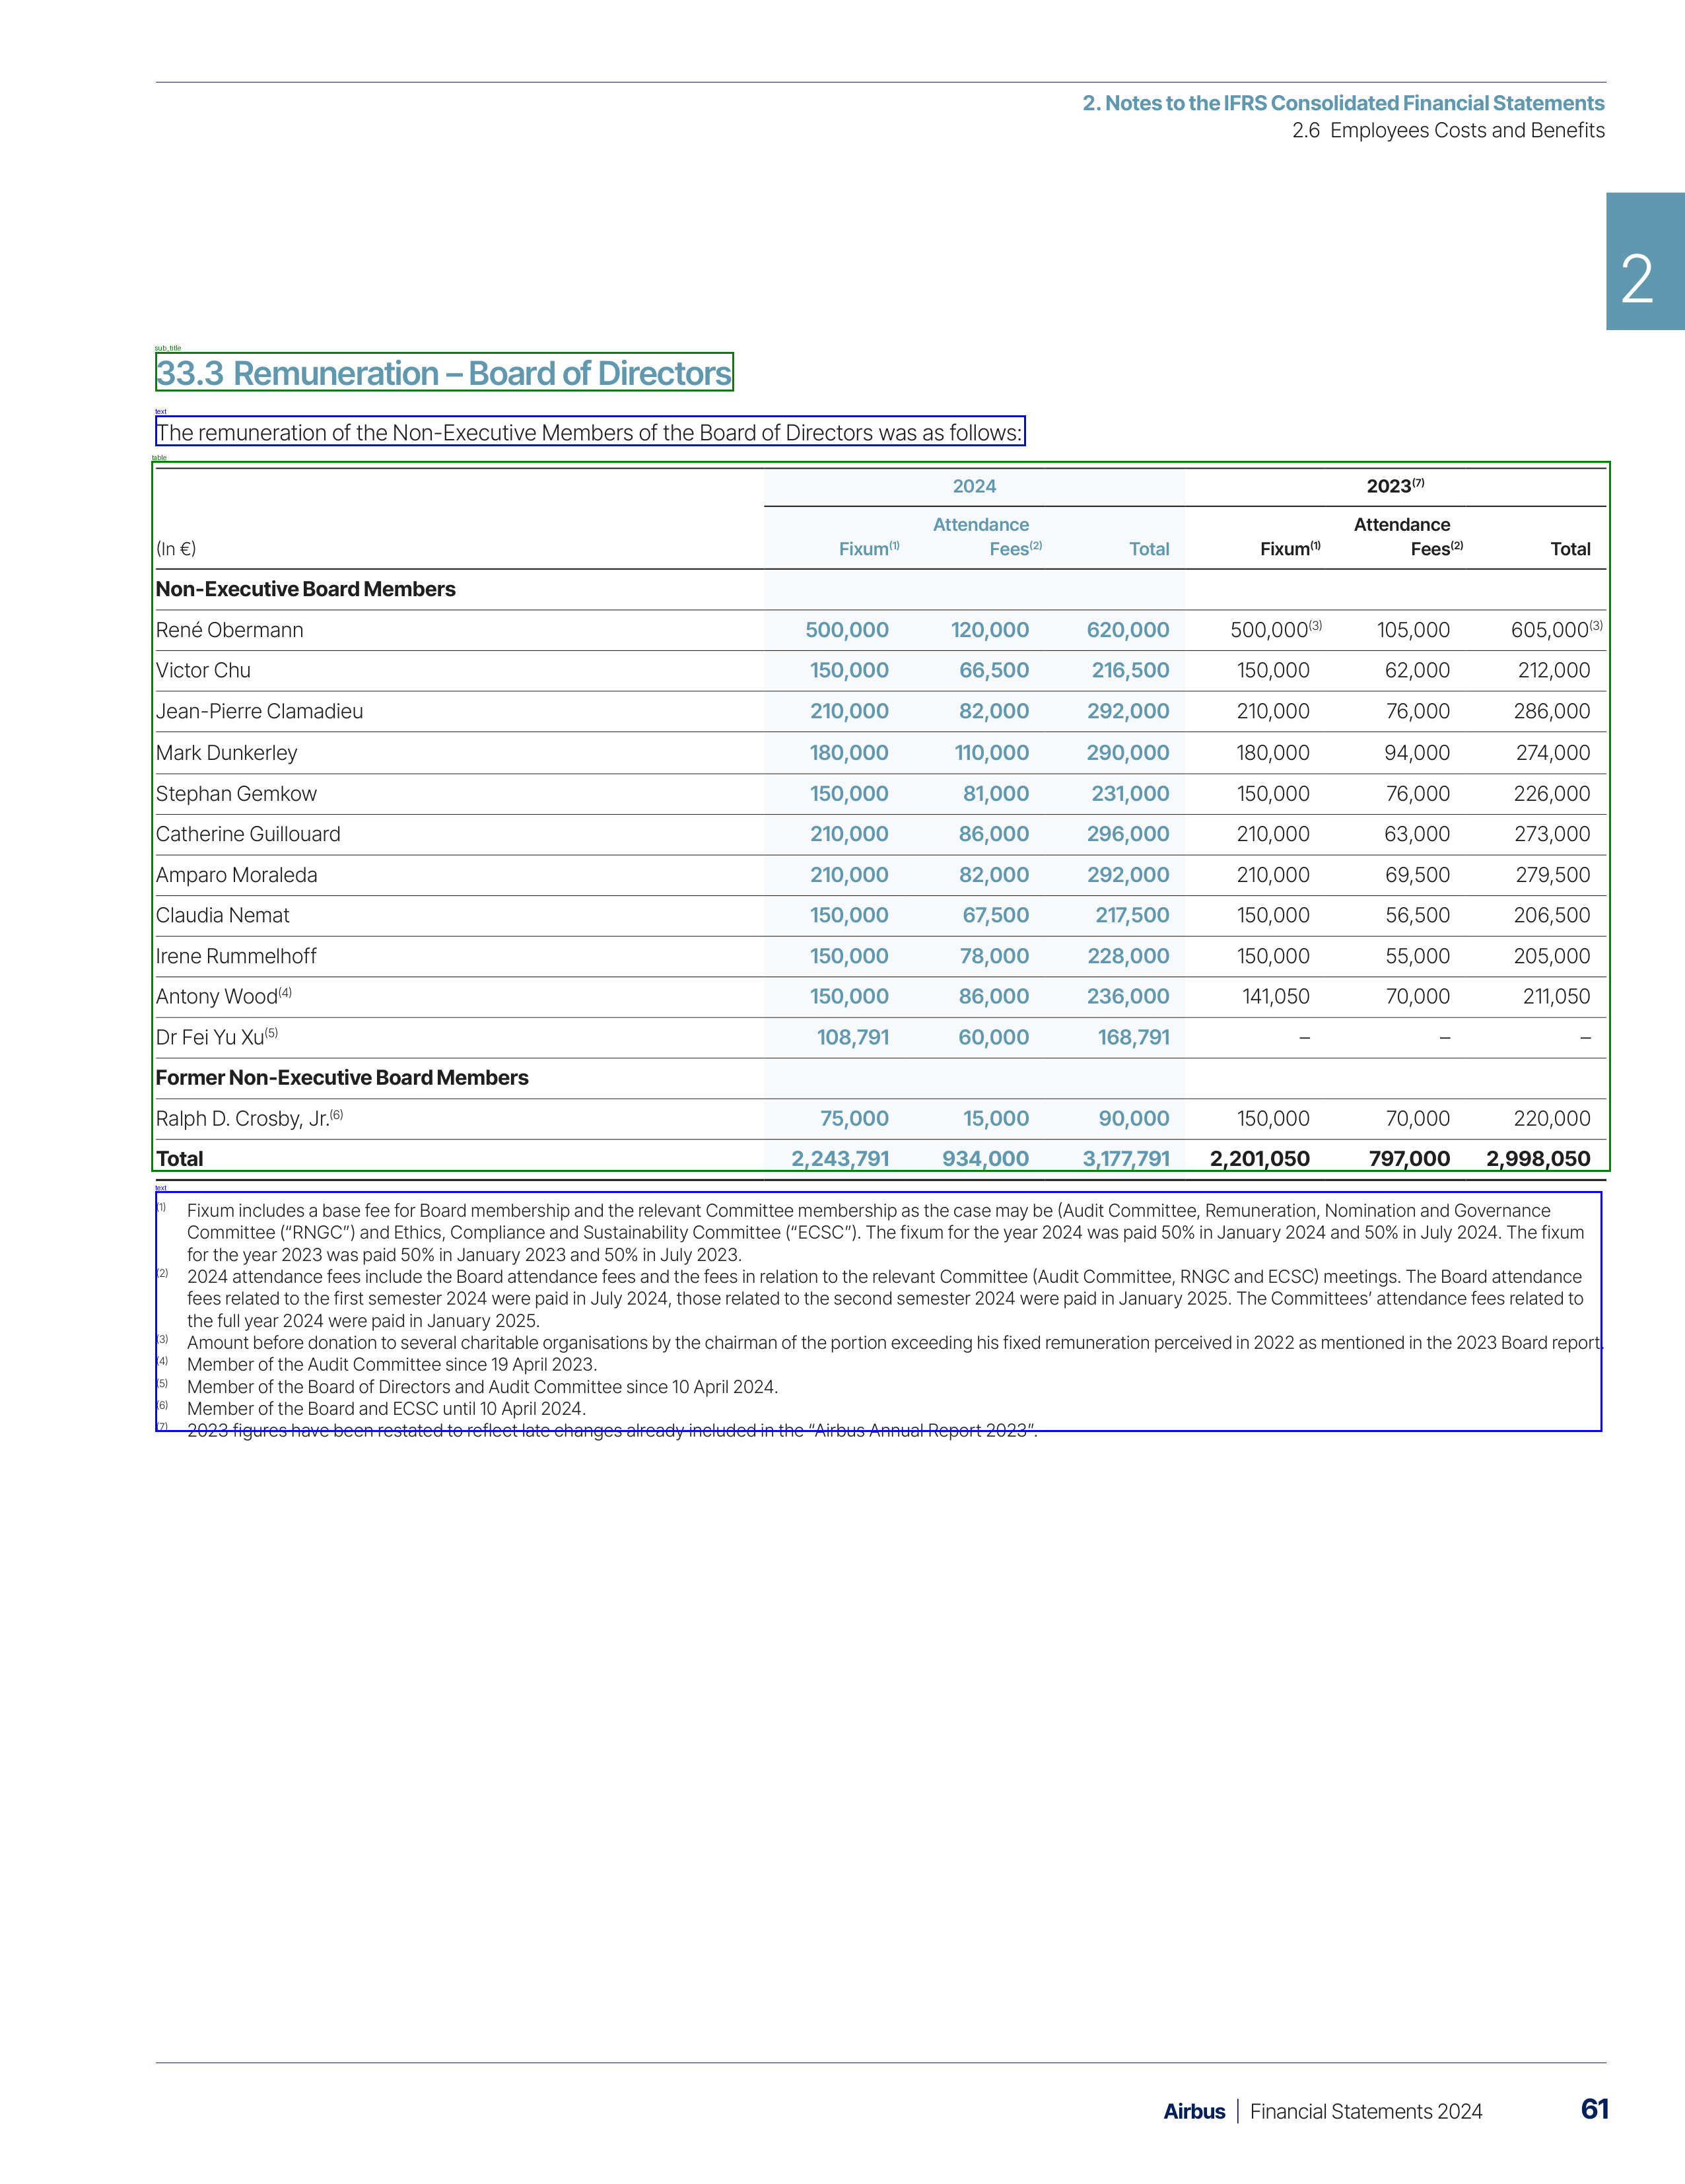

In [69]:
import tempfile
import sys

from io import StringIO

# Convert first PDF page to temp PNG
tmp = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
images[1].save(tmp.name, format="PNG")
image_path = tmp.name

prompt = "<image>\n<|grounding|>Convert the document to markdown."
# prompt = "<image>\nLocate <|ref|>table<|/ref|> in the image."



stdout = sys.stdout
sys.stdout = StringIO()

dim = 1024

model.infer(
    tokenizer,
    prompt=prompt,
    image_file=image_path,   # <-- file path, not PIL image
    output_path='data/output',
    base_size=dim,
    image_size=dim,
    crop_mode=False,
    save_results=True,
    test_compress=True
)

result = '\n'.join([l for l in sys.stdout.getvalue().split('\n') 
                    if not any(s in l for s in ['image:', 'other:', 'PATCHES', '====', 'BASE:', '%|', 'torch.Size'])]).strip()
sys.stdout = stdout

from PIL import Image, ImageDraw

def draw_bboxes(image_path, bboxes, save_path="boxed.png"):
    img = Image.open(image_path).convert("RGB")
    w, h = img.size
    draw = ImageDraw.Draw(img)

    colors = {
        "title": "red",
        "text": "blue",
    }

    for label, box_list in bboxes.items():
        for box in box_list:
            x1, y1, x2, y2 = box
            dim = 999
            x1, y1, x2, y2 = x1 / dim * w, y1 / dim * h, x2 / dim * w, y2 / dim * h
            draw.rectangle([x1, y1, x2, y2], outline=colors.get(label, "green"), width=3)
            draw.text((x1, y1 - 12), label, fill=colors.get(label, "green"))

    # img.save(save_path)
    return img

import re
import ast

def extract_bboxes(raw: str):
    """
    Extract labels and bounding boxes from DeepSeek-OCR grounding output.
    Returns a dict: { label: [ [x1,y1,x2,y2], ... ] }
    """
    pattern = r"<\|ref\|\>(.*?)<\|/ref\|\>.*?<\|det\|\>(.*?)<\|/det\|\>"
    matches = re.findall(pattern, raw, flags=re.DOTALL)

    out = {}
    for label, bbox_str in matches:
        # bbox_str is like: '[[44, 178, 460, 215]]'
        bboxes = ast.literal_eval(bbox_str)
        out.setdefault(label.strip(), []).extend(bboxes)

    return out
    
bboxes = extract_bboxes(result)
draw_bboxes(image_path, bboxes)

In [62]:
print(result)

<|ref|>title<|/ref|><|det|>[[44, 164, 258, 177]]<|/det|>

<|ref|>text<|/ref|><|det|>[[43, 179, 460, 215]]<|/det|>

<|ref|>text<|/ref|><|det|>[[43, 228, 468, 265]]<|/det|>

<|ref|>text<|/ref|><|det|>[[43, 278, 468, 328]]<|/det|>

<|ref|>text<|/ref|><|det|>[[44, 342, 468, 353]]<|/det|>

<|ref|>text<|/ref|><|det|>[[483, 179, 901, 240]]<|/det|>

<|ref|>text<|/ref|><|det|>[[483, 253, 904, 315]]<|/det|>

<|ref|>text<|/ref|><|det|>[[483, 330, 904, 354]]<|/det|>

<|ref|>title<|/ref|><|det|>[[44, 367, 232, 379]]<|/det|>

<|ref|>text<|/ref|><|det|>[[44, 380, 632, 392]]<|/det|>

<|ref|>table<|/ref|><|det|>[[42, 402, 904, 644]]<|/det|>

<|ref|>text<|/ref|><|det|>[[43, 658, 458, 683]]<|/det|>

<|ref|>text<|/ref|><|det|>[[483, 658, 886, 707]]<|/det|>

<|ref|>title<|/ref|><|det|>[[44, 720, 184, 731]]<|/det|>

<|ref|>text<|/ref|><|det|>[[44, 733, 589, 745]]<|/det|>

<|ref|>title<|/ref|><|det|>[[44, 757, 142, 768]]<|/det|>

<|ref|>text<|/ref|><|det|>[[43, 770, 468, 845]]<|/det|>

<|ref|>text<|/ref|><|d